In [127]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

#sklearn
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

#pytorch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from torch.utils.data import random_split
import torch

Plan:
Logistic Regression,
Random Forest,
Support Vector Machine,
PyTorch Classifier.

In [66]:
#reading the file
path = './diabetes_012_health_indic ators_BRFSS2021.csv'
diabetes_data = pd.read_csv(path)

#there are 236378 rows with 21 features and 1 multiclass target
diabetes_data.shape

(236378, 22)

In [67]:
#head of the data
pd.set_option('display.max_columns', 22)
diabetes_data.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0,1.0,1,15.0,1.0,0.0,0.0,0,1,1,0,1,0.0,5.0,10.0,20.0,0.0,0,11,4.0,5.0
1,2.0,1,0.0,1,28.0,0.0,0.0,1.0,0,1,0,0,1,0.0,2.0,0.0,0.0,0.0,0,11,4.0,3.0
2,2.0,1,1.0,1,33.0,0.0,0.0,0.0,1,1,1,0,1,0.0,2.0,10.0,0.0,0.0,0,9,4.0,7.0
3,2.0,0,1.0,1,29.0,0.0,1.0,1.0,1,1,1,0,1,0.0,5.0,0.0,30.0,1.0,1,12,3.0,4.0
4,0.0,0,0.0,1,24.0,1.0,0.0,0.0,0,0,0,0,1,0.0,3.0,0.0,0.0,1.0,1,13,5.0,6.0


In [68]:
#check for null values
diabetes_data.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [69]:
#drop duplicates if any
diabetes_data.drop_duplicates(inplace = True, ignore_index = True)
diabetes_data.shape

(223550, 22)

In [70]:
#types of columns
diabetes_data.dtypes

Diabetes_012            float64
HighBP                    int64
HighChol                float64
CholCheck                 int64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity              int64
Fruits                    int64
Veggies                   int64
HvyAlcoholConsump         int64
AnyHealthcare             int64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                       int64
Age                       int64
Education               float64
Income                  float64
dtype: object

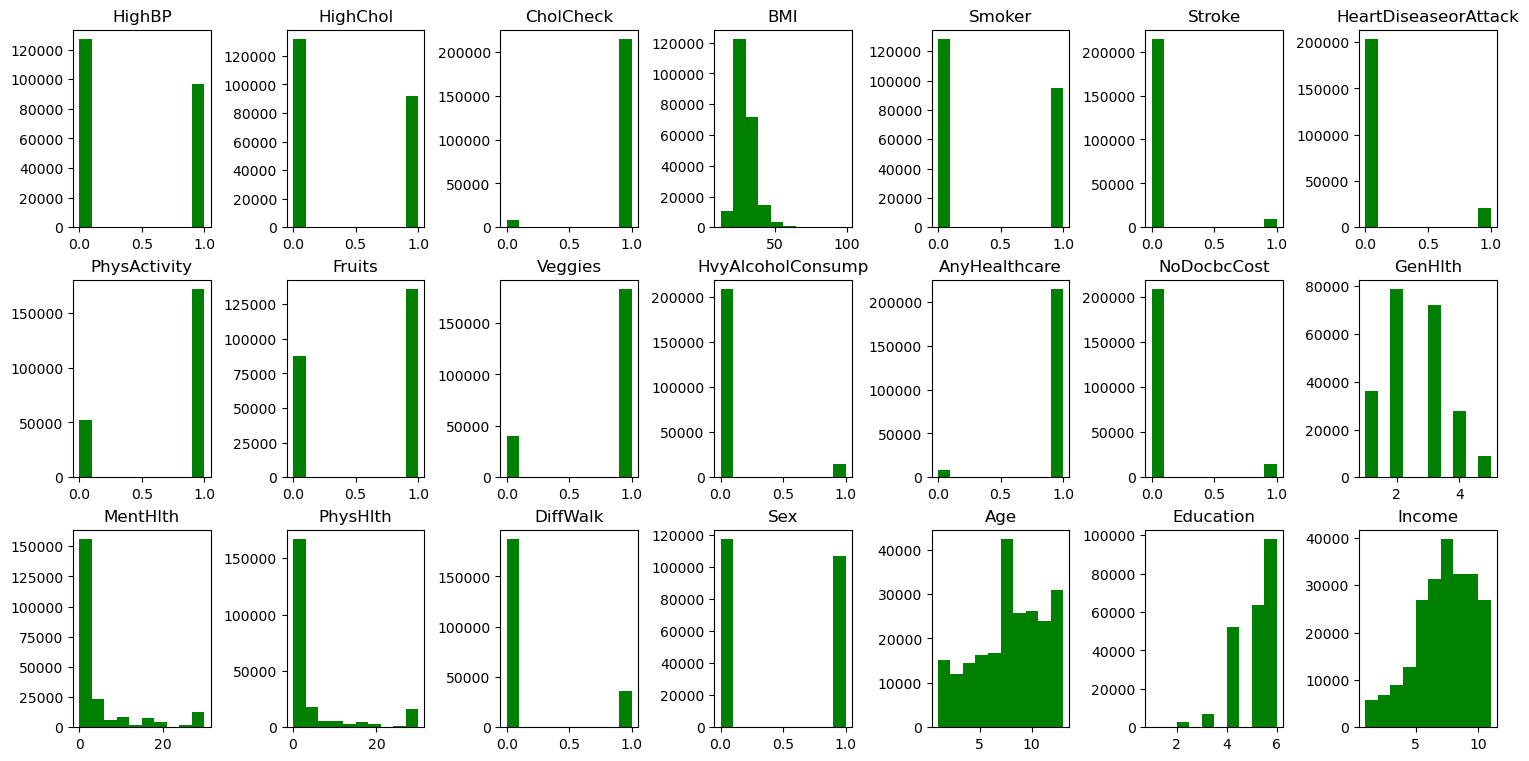

In [71]:
#plotting the distribution of features
rows = 3
columns = 7
fig, axs = plt.subplots(rows, columns, figsize=(15,7.5), layout = 'constrained')
for i in range(0, rows):
    for j in range(0, columns):
        axs[i, j].hist(diabetes_data.iloc[:, columns * i + j + 1], color='green')
        axs[i,j].set_title(diabetes_data.columns[columns * i + j + 1])


plt.show()

In [72]:
#from the distributions it's clear which types of features we have
categorical = ['GenHlth', 'Age', 'Education', 'Income']
dummies = ['HighBP', 'HighChol', 'CholCheck', 'Smoker','Stroke',
           'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
           'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk','Sex']
numeric = ['MentHlth', 'PhysHlth', 'BMI']

#making types more consistent
diabetes_data[categorical] = diabetes_data[categorical].astype(int)
diabetes_data[numeric] = diabetes_data[numeric].astype(np.float32)
diabetes_data[dummies] = diabetes_data[dummies].astype(bool)

#dist of target variable
diabetes_data['Diabetes_012'].value_counts()

Diabetes_012
0.0    184542
2.0     33395
1.0      5613
Name: count, dtype: int64

In [ ]:
# Balanced weights will be used to fix imbalance 
#(we want to predict diabetes more often and not too afraid of predicting it wrongly)

Text(0.5, 1.0, 'Heatmap for numeric variables')

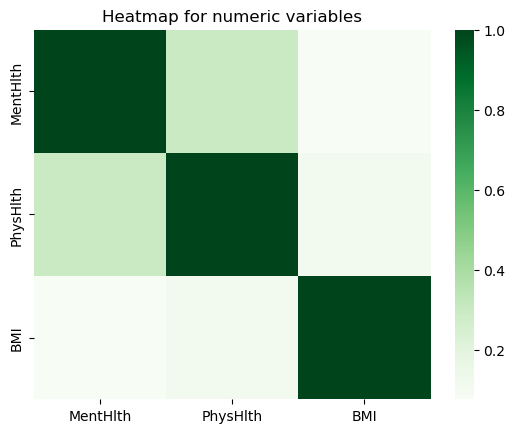

In [73]:
#no corr between numeric values
sns.heatmap(diabetes_data[numeric].corr(), cmap="Greens")
plt.title('Heatmap for numeric variables')

In [74]:
#transforming categorical variables into dummy variables and spliting into X and y
X = pd.get_dummies(diabetes_data, columns = categorical).drop(columns = ['Diabetes_012'])
y = diabetes_data['Diabetes_012']

In [75]:
#dividing to validation and non-validation sets
X_, X_val, y_, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [105]:
#Yaremych, H. E., Preacher, K. J., & Hedeker, D. (2023). Centering categorical predictors in multilevel models: Best practices and interpretation. Psychological methods, 28(3), 613.
#Scaler + logistic regression
#5 min for cv = 3 and train_size = 0.5
tic = time.time()

log_regr = LogisticRegressionCV(cv=3, random_state=42, class_weight = 'balanced')
pipe = make_pipeline(StandardScaler(), log_regr)
pipe.fit(X_, y_)
score_reg = pipe.score(X_val, y_val)

toc = time.time()
reg_time = toc - tic

print(score_reg)

0.6258107805859987


In [133]:
#getting permutation importance
model_fi = permutation_importance(pipe, X_val, y_val)
feature_importance = pd.DataFrame({'Feature': X_.columns,
                                   'Importance': model_fi.importances_mean,
                                   'Standard Deviation': model_fi.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index()
feature_importance = feature_importance[:21].sort_values('Importance', ascending=True)


Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

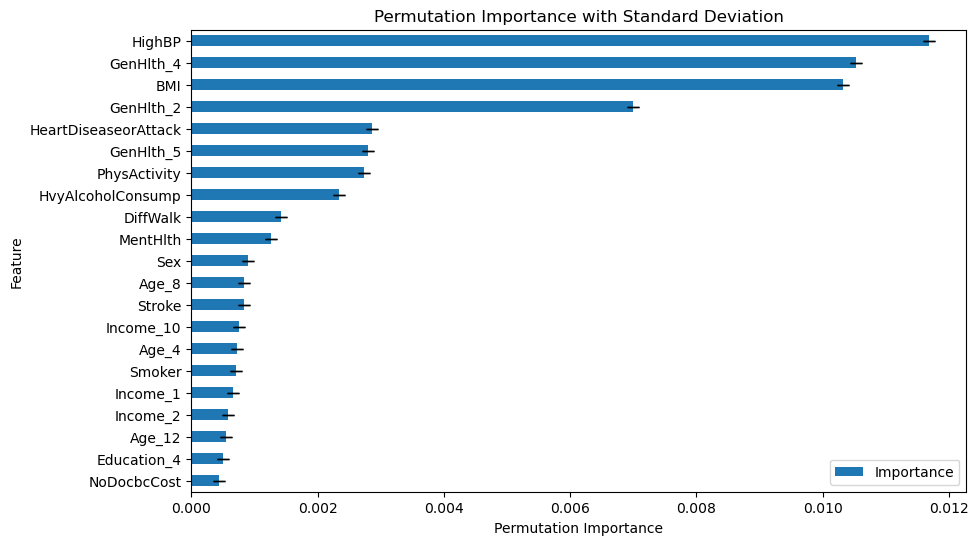

In [134]:
#permutation importance graph
ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')

In [135]:
#let's use top 16 features
top_features = feature_importance[5:]['Feature']
top_features

15                  Smoker
14                   Age_4
13               Income_10
12                  Stroke
11                   Age_8
10                     Sex
9                 MentHlth
8                 DiffWalk
7        HvyAlcoholConsump
6             PhysActivity
5                GenHlth_5
4     HeartDiseaseorAttack
3                GenHlth_2
2                      BMI
1                GenHlth_4
0                   HighBP
Name: Feature, dtype: object

In [136]:
#RF Model with random grid and CV
#Scaling is not needed for RF, however I cut the set of features for the sake of efficiency (taking top16 best features)
tic = time.time()


#entropy criterion for multiclass
forest_model = RandomForestClassifier(criterion = "entropy", random_state=42, class_weight = 'balanced')
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
               'min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)],
               'min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 10, num = 3)],
               'bootstrap': [True, False]}

rf_random = RandomizedSearchCV(estimator = forest_model, param_distributions = random_grid, \
                               n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_[list(top_features)], y_)

toc = time.time()
rf_time = toc - tic

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   8.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=  29.9s


/Users/macbookair13m22022/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=50; total time=   8.2s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=  30.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=4, n_estimators=50; total time=   5.9s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=  17.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=150; total time=  28.1s
[CV] END bootstrap=False, max_depth=80, max_features=log2, min_samples_leaf=10, min_samples_split=6, n_estimators=350; total time=  53.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=350; total time=  45.4s
[CV] END bootstrap=True, max_depth=30, m

In [145]:
rf_random.best_params_

{'n_estimators': 350,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [138]:
rf_random.best_score_

0.6761549740301698

In [146]:
#RF score on validation test
score_rf = rf_random.score(X_val[list(top_features)], y_val)
print(score_rf)

0.6641019906061284


In [140]:
# SVM with random grid search
# rbf kernel is used as I assume that non-diabetes class could be grouped as n-dim ball in the hyperplane
# Scaler and feature cut to increase efficiency
# Computational time rises at least quadratically with the increase of the sample
# however SVM does not require vast amount of data, so here I use just a fraction of data for training

tic = time.time()

X_svm, x_leftover, y_svm, y_leftover = train_test_split(X_, y_, test_size = 0.9, random_state = 42)

vector_machine = svm.SVC(decision_function_shape='ovo', kernel = 'rbf', class_weight = 'balanced')

#C is inversely proportional to the strictness of algorithm
random_grid = {'C': [int(x) for x in np.linspace(1, 1000, 10)]}

svm_random = RandomizedSearchCV(estimator = vector_machine, param_distributions = random_grid, \
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

pipe_svm = make_pipeline(StandardScaler(), svm_random)
pipe_svm.fit(X_svm[list(top_features)], y_svm)


toc = time.time()
svm_time = toc - tic

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [147]:
#non-strict algorithm is the best. Classes are not well-grouped unfortunately
svm_random.best_params_

{'C': 889}

In [142]:
#SVM score
score_svm = pipe_svm.score(X_val[list(top_features)], y_val)
print(score_svm)

0.6167747707447998


In [87]:
#class for pytorch dataset
#here label is one-hot encoded to the vector of size (1,3) 
class DiabetesDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        df = pd.read_csv(csv_path)
        df.drop_duplicates(inplace = True, ignore_index = True)
        
        categorical = ['GenHlth', 'Age', 'Education', 'Income']
        
        #dummies from categorical variables
        features = pd.get_dummies(df, columns = categorical).drop(columns = ['Diabetes_012']).astype(np.float32)
        target = np.array(df['Diabetes_012'].astype(str)).reshape(-1,1)
        
        #onehotencoder for 3 class label
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(target)
        target = ohe.transform(target)
        
        self.features = features.to_numpy()
        self.target = target
    
    def __len__(self):
        super().__init__()
        return len(self.target)
    
    def __getitem__(self, idx):
        super().__init__()
        
        return self.features[idx], self.target[idx]

In [88]:
dataset = DiabetesDataset(csv_path = './diabetes_012_health_indicators_BRFSS2021.csv')

#random split for train and test
generator = torch.Generator().manual_seed(42)
dataset_train, dataset_test = random_split(dataset, [0.9, 0.1], generator = generator)

#creating a dataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset_train,
    batch_size=200,
    shuffle=True,
)

#creating a dataLoader based on dataset_test
dataloader_test = DataLoader(
    dataset_test,
    batch_size=200,
    shuffle=True,
)

# A batch of features and labels (just to check)
features, labels = next(iter(dataloader_train))
print(features, labels)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 1., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.]]) tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.]

In [89]:
#NN class with 2 activation layers and linear classifier in the end
# for faster learning and to avoid gradient problems - batch normalization for each activation layer
# weight initialization to prevent problems with gradients
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(52,18)
        self.fc2 = nn.Linear(18,9)
        self.classifier = nn.Linear(9,3)
        
        self.bn1 = nn.BatchNorm1d(18)
        self.bn2 = nn.BatchNorm1d(9)
        
        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        
    def forward(self, x):
        # Pass x through linear layers adding activations
        x = self.bn1(nn.functional.elu(self.fc1(x)))
        x = self.bn2(nn.functional.elu(self.fc2(x)))
        x = self.classifier(x)
        return x

In [113]:
net = Net()
# CrossEntropy for multiclass task
class_weights = [0.1745, 0.85, 0.975]
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights))
# Adam optimizer 
optimizer = optim.Adam(net.parameters(), lr= 0.001)

tic = time.time()
#training for 10 epochs
#Loss does not imporve after 10 epochs here
for epoch in range(10):
    running_loss = 0.0
    # Iterate over training batches
    for features,labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

toc = time.time()
nn_time = toc - tic

Epoch 1, Loss: 0.2451
Epoch 2, Loss: 0.2279
Epoch 3, Loss: 0.2273
Epoch 4, Loss: 0.2271
Epoch 5, Loss: 0.2268
Epoch 6, Loss: 0.2265
Epoch 7, Loss: 0.2263
Epoch 8, Loss: 0.2262
Epoch 9, Loss: 0.2260
Epoch 10, Loss: 0.2260
Epoch 11, Loss: 0.2260
Epoch 12, Loss: 0.2259
Epoch 13, Loss: 0.2256
Epoch 14, Loss: 0.2256
Epoch 15, Loss: 0.2255


In [125]:
# Calculating accuracy on test set
accuracy = []

y_predicted = np.array([])
y_real = np.array([])

net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        outputs = net(features)
        acc = (torch.argmax(outputs, 1) == torch.argmax(labels, 1)).float().mean()
        
        #saving predictions and labels
        y_predicted = np.concatenate((y_predicted, torch.argmax(outputs, 1)), axis=0)
        y_real = np.concatenate((y_real, torch.argmax(labels, 1)), axis=0)
        
        accuracy.append(acc)

print(np.mean(accuracy))

0.68130904


In [144]:
# We can see a slight improvement at  NN and RF comparing to the baseline Log Regression
# However these distinctions look significant 
# In terms of time NN works faster than others
print(f"""Accuracy for Log Regression: {score_reg}, Time (sec): {round(reg_time,2)}
Accuracy for Random Forest {score_rf}, Time (sec): {round(rf_time,2)}
Accuracy for SVM {score_svm}, Time (sec): {round(svm_time,2)}
Accuracy for NN {np.mean(accuracy)}, Time (sec): {round(nn_time,2)}""")


Accuracy for Log Regression: 0.6258107805859987, Time (sec): 434.97
Accuracy for Random Forest 0.6641019906061284, Time (sec): 428.73
Accuracy for SVM 0.6167747707447998, Time (sec): 316.13
Accuracy for NN 0.6813090443611145, Time (sec): 25.65


Prospect for the future improvement:
Most likely we are not afraid to mislabel non-diabetes class and want maximize correctly predicted diabetes class.
Wrong prediction of diabetes costs one health check for a person, whereas non-predicted diabetes can be dangerous for life.
Thus, depending on business requirements, weights for classes could be adjusted.
For now let's look at confusion matrix.

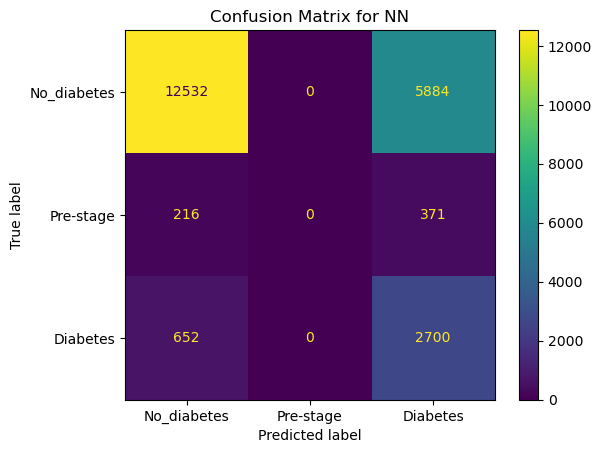

In [132]:
cm = confusion_matrix(y_real, y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['No_diabetes', 'Pre-stage', 'Diabetes'])
disp.plot()
plt.title('Confusion Matrix for NN')
plt.show()

In [ ]:
#We have high recall for the Diabetes class, which is good
#Model does a poor job with Pre-stage recognition and classifies it as having diabetes
#I suggest that symptoms of pre-diabetes and diabetes are the same, it is possible to merge 2 classes
#For high recall at Diabetes class we pay with lower accuracy no_diabetes class